In [1]:
import alifedata_phyloinformatics_convert as apc
from Bio import Phylo
from collections import defaultdict 
from hstrat2 import hstrat
import itertools as it
import networkx as nx
from networkx.algorithms.components.connected import connected_components as nx_connected_components
import pandas as pd
import pulp
import random


In [2]:
random.seed(5)


# data generation

In [3]:
population_size = 100
ancestor = hstrat.HereditaryStratigraphicColumn(hstrat.fixed_resolution_algo.Policy(10))
pop = [ancestor.Clone() for __ in range(population_size)]

for gen in range(10000):
    pop[random.randint(0, len(pop) - 1)] = random.choice(pop).CloneDescendant()


# problem setup

In [4]:
# arbitrary large value used for linear programming hacks
# https://en.wikipedia.org/wiki/Big_M_method
big_M = 10**9


In [5]:
# surveyed taxa
taxa = [chr(ord("a") + j) for j in range(len(pop))]


In [6]:
# pairwise hard UPPER bounds for MRCA generation
# (i.e., MRCA is AT or BEFORE these bounds)
# note that node names are generated by concatenation of sorted taxa
dist = {
    ''.join(sorted([chr(ord("a") + i),chr(ord("a") + j)])) 
    : hstrat.calc_rank_of_first_retained_disparity_between(pop[i], pop[j])
    for i in range(len(pop))
    for j in range(len(pop))
    if i != j
}

err = {
    ''.join(sorted([chr(ord("a") + i),chr(ord("a") + j)])) 
    : hstrat.calc_rank_of_last_retained_commonality_between(pop[i], pop[j])
    for i in range(len(pop))
    for j in range(len(pop))
    if i != j
}

In [7]:
# all possible pairings of taxa (i.e., distances in our distance matrix)
taxa_pairs = [''.join(sorted(pair)) for pair in it.combinations(taxa, 2)]
assert set(taxa_pairs) == set(dist.keys()), "mismatch between distance matrix and taxa"


In [8]:
model = pulp.LpProblem(name='MRCA_Inference', sense=pulp.LpMaximize)


# variable setup

In [9]:
mrca_dict = {}
obj_dict = {}
#input: two leaves
def get_mrca(a, b):
    key = frozenset((a, b))
    name = ''.join(sorted(key))
    if key not in mrca_dict:
        mrca_dict[key] = pulp.LpVariable(
            name,
            lowBound=0,
            upBound=dist[name],
            cat=pulp.LpInteger,
        )
        obj_dict[key] = pulp.LpVariable(
            name + 'objective',
            lowBound=0,
            upBound=err[name],
            cat=pulp.LpInteger,
        )
    
    return mrca_dict[key]


In [10]:
lt_dict = {}
# input: two leaf-pairs
def get_lt(a, b):
    assert a != b
    if a > b:
        return get_gt(b, a)

    assert a < b
    key = frozenset((a, b))
    first, second = a, b
    name = f'{first}_lt_{second}'
    if key not in lt_dict:
        lt_dict[key] = pulp.LpVariable(
            name,
            lowBound=0,
            upBound=1,
            cat=pulp.LpInteger,
        )
    
    return lt_dict[key]


In [11]:
eq_dict = {}
# input: two leaf-pairs
def get_eq(a, b):
    assert a != b
    key = frozenset((a, b))
    first, second = sorted(key)
    name = f'{first}_eq_{second}'
    if key not in eq_dict:
        eq_dict[key] = pulp.LpVariable(
            name,
            lowBound=0,
            upBound=1,
            cat=pulp.LpInteger,
        )
    
    return eq_dict[key]


In [12]:
gt_dict = {}
# input: two leaf-pairs
def get_gt(a, b):
    assert a != b
    if a > b:
        return get_lt(b, a)

    assert a < b
    key = frozenset((a, b))
    first, second = a, b
    name = f'{first}_gt_{second}'
    if key not in gt_dict:
        gt_dict[key] = pulp.LpVariable(
            name,
            lowBound=0,
            upBound=1,
            cat=pulp.LpInteger,
        )

        xx = a
        yy = b
        # lookup (or generate) PuLP variables
        xx_mrca = get_mrca(*xx)
        yy_mrca = get_mrca(*yy)

        xx_eq_yy = get_eq(xx, yy)
        xx_lt_yy = get_lt(xx, yy)
        xx_gt_yy = gt_dict[key]

        global model
        
        # lt, gt, and eq are mutually exclusive
        model += xx_lt_yy + xx_gt_yy + xx_eq_yy == 1

        # attach lt/gt to MRCA generation values
        model += -big_M * xx_lt_yy + xx_gt_yy <= (xx_mrca - yy_mrca)
        model += -big_M * xx_gt_yy + xx_lt_yy <= -(xx_mrca - yy_mrca)
        
    return gt_dict[key]


# constraint setup

In [13]:
# set up pairwise MRCA generation comparison variables
# for xx, yy in it.combinations(taxa_pairs, 2):
#     if xx < yy:
#             # lookup (or generate) PuLP variables
#             xx_mrca = get_mrca(*xx)
#             yy_mrca = get_mrca(*yy)

#             xx_eq_yy = get_eq(xx, yy)
#             xx_lt_yy = get_lt(xx, yy)
#             xx_gt_yy = get_gt(xx, yy)

#             # lt, gt, and eq are mutually exclusive
#             model += xx_lt_yy + xx_gt_yy + xx_eq_yy == 1

#             # attach lt/gt to MRCA generation values
#             model += -big_M * xx_lt_yy + xx_gt_yy <= (xx_mrca - yy_mrca)
#             model += -big_M * xx_gt_yy + xx_lt_yy <= -(xx_mrca - yy_mrca)

# add node consolidation logic
# goal AB < AC ===> BC == AC  (if then statement)
# strategy: ab_lt_ac <= bc_eq_ac
def tripletwise(iterable):
    # pairwise('ABCDEFG') --> AB BC CD DE EF FG
    a, x = it.tee(iterable)
    b, c = it.tee(x)
    next(b, None)
    next(c, None)
    next(c, None)

    return zip(a, b, c)

# for x, y, z in tripletwise(taxa + taxa[:2]): # why isn't this combinations?
for __ in range(10000):
    random.shuffle(taxa)
    for x, y, z in [taxa[:3]]: # why isn't this combinations?

# for x,y,z in it.combinations(taxa, 3):
        xy = ''.join(sorted([x, y]))
        xz = ''.join(sorted([x, z]))
        yz = ''.join(sorted([y, z]))

        # why isn't this get_lt?, is something backwards?
        model += get_gt(xy, xz) <= get_eq(yz, xz)


In [14]:
for key in mrca_dict:
    model += obj_dict[key] <= mrca_dict[key]

# optimization setup

In [15]:
# maximum likelihood comes from pushing generations of internal nodes as far forward as possible
model += sum(obj_dict.values())


# solve

In [16]:
model


MRCA_Inference:
MAXIMIZE
1*abobjective + 1*acobjective + 1*aeobjective + 1*afobjective + 1*agobjective + 1*ahobjective + 1*aiobjective + 1*ajobjective + 1*akobjective + 1*alobjective + 1*amobjective + 1*anobjective + 1*apobjective + 1*arobjective + 1*asobjective + 1*auobjective + 1*avobjective + 1*awobjective + 1*axobjective + 1*ayobjective + 1*azobjective + 1*a|objective + 1*a}objective + 1*a~objective + 1*aobjective + 1*aobjective + 1*aobjective + 1*aobjective + 1*aobjective + 1*aobjective + 1*a
objective + 1*aobjective + 1*aobjective + 1*aobjective + 1*aobjective + 1*aobjective + 1*aobjective + 1*aobjective + 1*aobjective + 1*aobjective + 1*aobjective + 1*aobjective + 1*aobjective + 1*aobjective + 1*aobjective + 1*aobjective + 1*aobjective + 1*aobjective + 1*aobjective + 1*aobjective + 1*a objective + 1*a¡objective + 1*a¢objective + 1*a¤objective + 1*a¥objective + 1*a¦objective + 1*a§objective + 1*a¨objective + 1*a©objective + 1*aªobjective + 1*a¬objective +

In [17]:
model.solve()


1

In [18]:
pulp.LpStatus[model.status]


'Optimal'

# inspect results

In [19]:
for var in mrca_dict.values():
    print(var, var.varValue)


t 70.0
 90.0
² 40.0
²¿ 70.0
{ 60.0
{Ã 60.0
| 70.0
Ã 60.0
a¡ 100.0
¡ 60.0
 70.0
 60.0
 60.0
 70.0
·½ 60.0
½¾ 40.0
¦ 70.0
¦¼ 60.0
ª 60.0
iº 40.0
º 60.0
¸ 40.0
¹ 40.0
n 60.0
­ 90.0
s 90.0
 70.0
c 40.0
c¤ 40.0
q 60.0
z 90.0
~ 40.0
~¼ 60.0
f 70.0
f¶ 60.0
b 60.0
e 60.0
¥ 40.0
¥ 40.0
b 40.0
 40.0
½ 70.0
± 90.0
± 40.0
 60.0
 90.0
e 60.0
e 60.0
 60.0
 40.0
ft 90.0
t 40.0
w 40.0
w 60.0
§ 90.0
§¹ 90.0
m 60.0
 60.0
£ 60.0
¯ 60.0
±· 90.0
·¾ 40.0
¼ 100.0
º¼ 70.0
± 70.0
Ã 60.0
w¾ 40.0
¾ 40.0
r¾ 90.0
¾ 40.0
h¬ 40.0
¢¬ 70.0
xÃ 60.0
´Ã 60.0
q 60.0
¶ 60.0
r} 90.0
} 40.0
µ 40.0
· 60.0
· 90.0
¨· 60.0
cu 40.0
lu 40.0
¬· 70.0
·À 60.0
¬¹ 70.0
¬¼ 70.0
b¶ 70.0
¶ 70.0
¤¦ 90.0
¦Ã 70.0
f 70.0
fÄ 60.0
f 60.0
f 40.0
h{ 40.0
{§ 60.0
yµ 40.0
µ¾ 90.0
d¿ 70.0
·¿ 70.0
e§ 60.0
§ 90.0
· 60.0
¡· 90.0
d 70.0
 60.0
a² 90.0
b² 60.0
ek 40.0
k 40.0
x¡ 60.0
¡¯ 60.0
wz 60.0
z{ 60.0
´ 70.0
´Ä 60.0
x 60.0
 70.0
¢£ 60.0
¢° 60.0
i 40.0
iª 40.0
bd 60.

} 40.0
i¾ 90.0
¾Ä 40.0
ov 40.0
n¦ 60.0
¦ 60.0
k³ 40.0
³ 60.0
®µ 40.0
µº 40.0
¬ 90.0
l£ 40.0
m 60.0
º 70.0
n 60.0
 90.0
v 70.0
  90.0
u© 70.0
¾ 40.0
²¾ 40.0
°» 60.0
¼Â 40.0
v 60.0
¤ 60.0
f¯ 60.0
¢¯ 60.0
pÃ 40.0
¿Ä 60.0
wx 70.0
w 60.0
© 40.0
¨ 60.0
¦© 70.0
bs 60.0
« 40.0
 90.0
j 40.0
j 40.0
¢ 90.0
i¤ 40.0
b¯ 60.0
v~ 60.0
~Ä 60.0
 40.0
t¹ 70.0
 ¹ 90.0
i¸ 40.0
x¼ 60.0
µ 90.0
° 40.0
­° 60.0
 60.0
 40.0
¥ 40.0
fq 60.0
f¹ 70.0
g 70.0
l 40.0
s} 40.0
}µ 90.0
¸º 60.0
u 60.0
u½ 70.0
® 70.0
 60.0
x© 60.0
ÁÄ 70.0
fi 40.0
©¸ 70.0
²¼ 90.0
l 40.0
¸ 60.0
° 60.0
{¦ 60.0
§ 60.0
 § 90.0
 60.0
{ 60.0
k 40.0
´¹ 90.0
fr 40.0
aÀ 60.0
»À 60.0
x 60.0
 60.0
x£ 60.0
¯ 60.0
¯ 40.0
­· 90.0
¨ 60.0
À 60.0
Ä 60.0
 40.0
°¸ 70.0
¦³ 60.0
¤µ 40.0
¢¸ 60.0
¼ 90.0
¦ 60.0
¦ 60.0
s­ 90.0
  60.0
hm 40.0
z 100.0
|¸ 60.0
b 40.0
f 40.0
j 40.0
m³ 70.0
¢ 70.0
Ä 60.0
© 70.0
¤ 60.0
¤ 60.0
¤Á 60.0
 60.0
x 60.0
e¶ 60.0
 60.0
ÀÃ 60.0
t½ 60.0
}¸ 40.0
² 90.0
 40.0

In [20]:
# for key in lt_dict.keys():
#     print(key)
#     for var in lt_dict[key], eq_dict[key], gt_dict[key]:
#         print('\t', var, var.varValue)


# reconstruct


In [21]:
# step 1: consolidate internal nodes

gen_to_pair = defaultdict(set)
for k, v in mrca_dict.items():
    gen_to_pair[v.varValue].add(k)

internal_nodes = []
for gen, pairs in sorted(gen_to_pair.items(), key=lambda item: item[0], reverse=True):
    G = nx.from_edgelist(pairs)
    components = nx_connected_components(G)
    for component in components:
        internal_nodes.append((gen, component))

internal_nodes


[(100.0, {'w', '¨', '®', 'À'}),
 (100.0, {'z', '\x9b', '¢', '´'}),
 (100.0, {'a', 's', '\x96', '\xa0', '¡'}),
 (100.0, {'\x86', '\x99', '\x9a', '¼'}),
 (100.0, {'\x83', '\x8f', '¹'}),
 (100.0, {'\x89', '³', 'Ä'}),
 (100.0, {'d', '\x80', '§', '\xad'}),
 (100.0, {'n', 'x'}),
 (90.0,
  {'b',
   '~',
   '\x7f',
   '\x8a',
   '\x8d',
   '\x90',
   '\x94',
   '\x9e',
   '£',
   '©',
   '°',
   '½',
   'Ã'}),
 (90.0,
  {'f',
   'g',
   'j',
   't',
   'v',
   '|',
   '\x88',
   '\x8c',
   '\x93',
   '\x95',
   '\x9f',
   'ª',
   '¬',
   'º',
   '»',
   '¿'}),
 (90.0,
  {'c',
   'h',
   'i',
   'k',
   'l',
   'p',
   'r',
   '}',
   '\x82',
   '\x87',
   '\x8b',
   '\x8e',
   '\x92',
   '\x9d',
   '«',
   'µ',
   '¾',
   'Â'}),
 (90.0, {'e', 'm', 'q', 'w', 'y', '{', '¨', '®', '¯', 'À', 'Á'}),
 (90.0,
  {'a',
   'd',
   's',
   'z',
   '\x80',
   '\x83',
   '\x84',
   '\x86',
   '\x8f',
   '\x91',
   '\x96',
   '\x99',
   '\x9a',
   '\x9b',
   '\x9c',
   '\xa0',
   '¡',
   '¢',
   '§',
   '\xa

In [22]:
# step 2: join branches

# maps node names (leaves and internal) to unique integers
uid_generator = defaultdict(lambda: len(uid_generator))

consolidated_to = {
    taxum : taxum
    for taxum in taxa
}
records = []
for gen, internal_node in internal_nodes:
    name = ''.join(sorted(internal_node))

    stitched = {
        consolidated_to[leaf]
        for leaf in internal_node
    }
    for leaf in internal_node:
        consolidated_to[leaf] = name

    for stitch in stitched:  
        records.append({
            'id' : uid_generator[stitch],
            'id_' : stitch,
            'name' : stitch,
            'origin_time' : gen,
            'ancestor_list' : f'{[uid_generator[name]]}',
            'ancestor_list_' : f'{[name]}',
        })

records.append({
    'id' : uid_generator[''.join(sorted(internal_nodes[-1][1]))],
    'id_' : ''.join(sorted(internal_nodes[-1][1])),
    'name' : ''.join(sorted(internal_nodes[-1][1])),
    'origin_time' : 0,
    'ancestor_list' : f'{[]}',
    'ancestor_list_' : f'{[]}',
})


In [23]:
# load into pandas dataframe in alife standard format
df_phylogeny = pd.DataFrame.from_records(records)
df_phylogeny


,id,id_,name,origin_time,ancestor_list,ancestor_list_
0,0,®,®,100.0,[1],['w¨®À']
1,2,¨,¨,100.0,[1],['w¨®À']
2,3,w,w,100.0,[1],['w¨®À']
3,4,À,À,100.0,[1],['w¨®À']
4,5,,,100.0,[6],['z\x9b¢´']
...,...,...,...,...,...,...
119,119,adfgjstvz| ¡¢§ª¬­±²´·¹º»¼¿,adfgjstvz| ¡¢§ª¬­±²´·¹º»¼¿,60.0,[122],['abdefgjmnqstuvwxyz{|~\x7f\x80\x81\x83\x84\x8...
120,120,bu~£¤¦©°¶¸½Ã,bu~£¤¦©°¶¸½Ã,60.0,[122],['abdefgjmnqstuvwxyz{|~\x7f\x80\x81\x83\x84\x8...
121,122,abdefgjmnqstuvwxyz{|~...,abdefgjmnqstuvwxyz{|~...,40.0,[123],['abcdefghijklmnopqrstuvwxyz{|}~\x7f\x80\x81\x...
122,116,chiklopr} ¥«µ¾Â,chiklopr} ¥«µ¾Â,40.0,[123],['abcdefghijklmnopqrstuvwxyz{|}~\x7f\x80\x81\x...


/usr/local/lib/python3.8/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127 () missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.8/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128 (\x80) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.8/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129 (\x81) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.8/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 130 (\x82) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.8/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 131 (\x83) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.8/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 132 (\x84) missing from current font.
  fig.canvas.print_figure

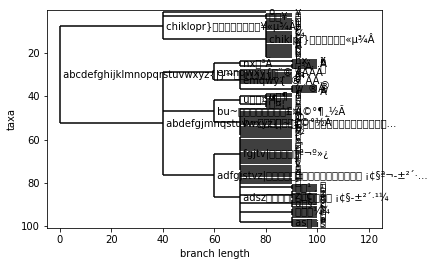

In [24]:
# convert to biopython and plot
tree = apc.alife_dataframe_to_biopython_tree(df_phylogeny, setup_branch_lengths=True)
tree.ladderize()
Phylo.draw(tree)
# note that origin_time isn't set quite correctly (off by one)
